# DisCoCat in lambeq

## Pregroup grammars

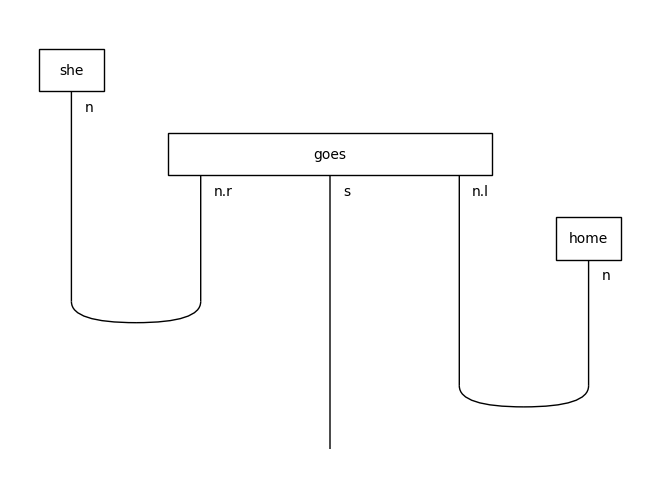

In [1]:
from lambeq.backend.drawing import draw
from lambeq.backend.grammar import Cap, Cup, Id, Ty, Word


n, s = Ty('n'), Ty('s')

words = [
    Word('she', n),
    Word('goes', n.r @ s @ n.l),
    Word('home', n)
]

cups = Cup(n, n.r) @ Id(s) @ Cup(n.l, n)

assert Id().tensor(*words) == words[0] @ words[1] @ words[2]
assert Ty().tensor(*[n.r, s, n.l]) == n.r @ s @ n.l

diagram = Id().tensor(*words) >> cups
draw(diagram)

Before normal form: she, goes, home, CUP, CUP
After normal form: she, goes, CUP, home, CUP


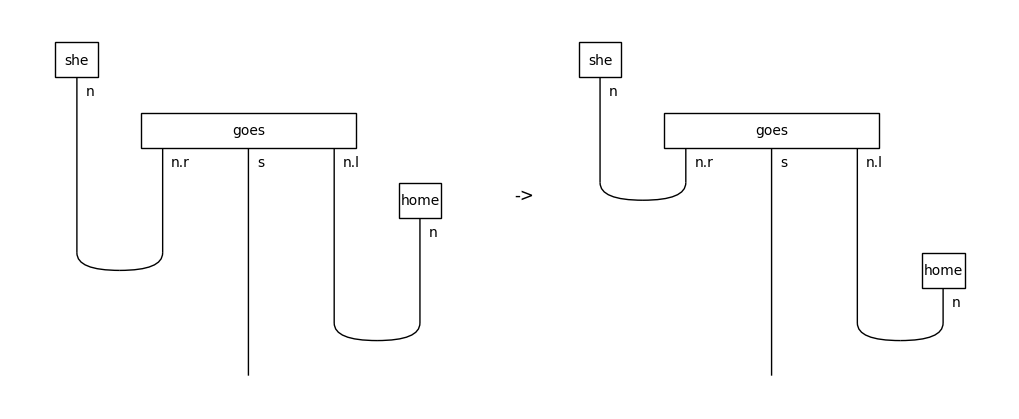

In [2]:
from lambeq.backend.drawing import draw_equation

# In the original diagram, words appear before the cups
print('Before normal form:', ', '.join(map(str, diagram.boxes)))

diagram_nf = diagram.normal_form()
print('After normal form:', ', '.join(map(str, diagram_nf.boxes)))

draw_equation(diagram, diagram_nf, symbol='->', figsize=(10, 4), draw_as_pregroup=False)

## Functors

### Example 1: "Very" functor

In [3]:
from lambeq import BobcatParser
parser = BobcatParser(verbose='suppress')

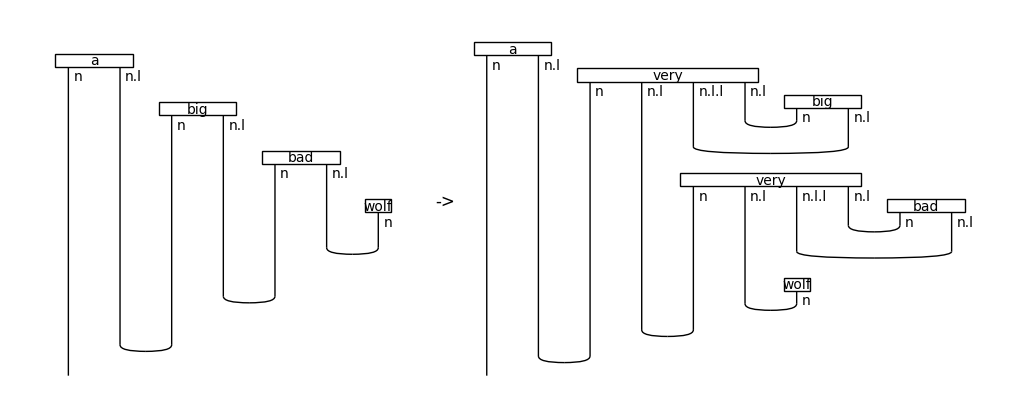

In [4]:
from lambeq.backend.drawing import draw_equation
from lambeq.backend.grammar import Diagram, grammar, Functor

# determiners have the same type as adjectives
# but we shouldn't add 'very' behind them
determiners = ['a', 'the', 'my', 'his', 'her', 'their']

# type for an adjective
adj = n @ n.l
very = Word('very', adj @ adj.l)
cups = Diagram.cups(adj.l, adj)

def very_ob(_, ty):
    return ty

def very_ar(_, box):
    if box != very:
        if box.name not in determiners:
            if box.cod == adj:
                return very @ box >> Id(adj) @ cups
    return box

very_functor = Functor(grammar,
                       ob=very_ob,
                       ar=very_ar,)

diagram = parser.sentence2diagram('a big bad wolf')
new_diagram = very_functor(diagram)

draw_equation(diagram, new_diagram, symbol='->', figsize=(10, 4), draw_as_pregroup=False)

### Example 2: Twist functor

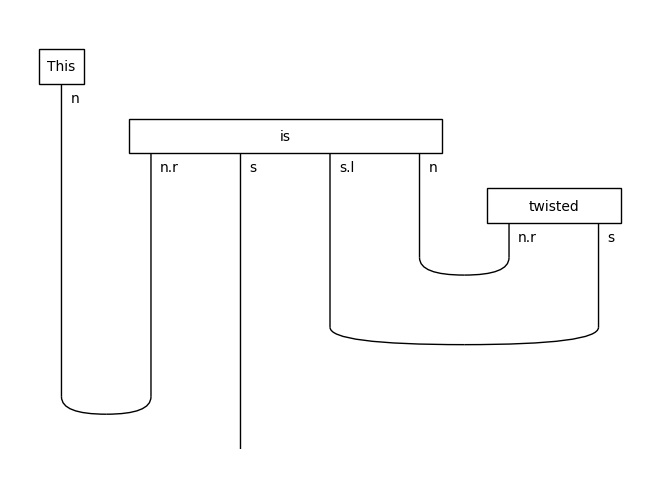

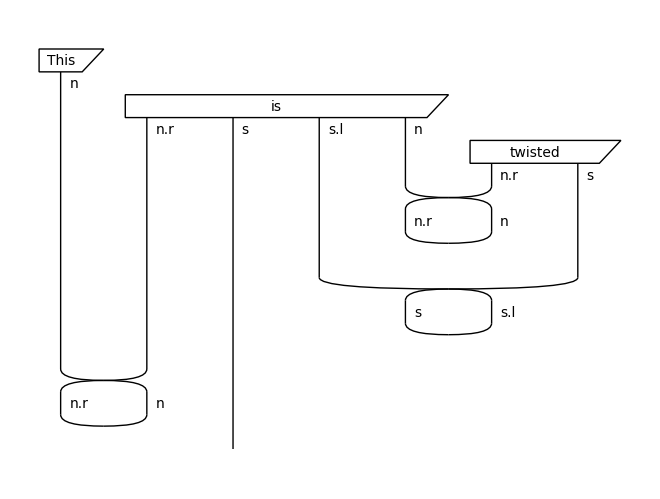

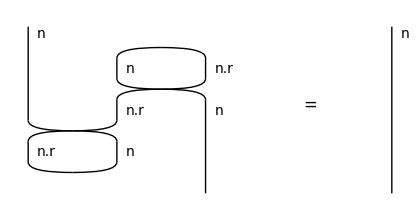

In [5]:
from lambeq.backend.grammar import Category, Ty, Layer, Diagram, Functor, Box, Cup, Cap, Swap


twisted = Category('twisted')

@twisted('Diagram')
class TwistedDiagram(Diagram): ...

@twisted('Ty')
class TwistedTy(Ty): ...

@twisted('Box')
class TwistedBox(Box): ...

@twisted('Layer')
class TwistedLayer(Layer): ...

class TwistedCup(Cup, TwistedBox): ...

class TwistedCap(Cap, TwistedBox): ...

@TwistedDiagram.register_special_box('swap')
class TwistedSwap(Swap, TwistedBox): ...

@TwistedDiagram.register_special_box('cap')
def twisted_cap_factory(left, right, is_reversed=False):
    caps = TwistedCap(right, left, is_reversed=not is_reversed)
    swaps = TwistedSwap(right, left)
    return caps >> swaps

@TwistedDiagram.register_special_box('cup')
def twisted_cup_factory(left, right, is_reversed=False):
    swaps = TwistedSwap(left, right)
    cups = TwistedCup(right, left, is_reversed=not is_reversed)
    return swaps >> cups


twist_functor = Functor(
    ob=lambda _, ty: TwistedTy(ty.name),
    ar=lambda func, box: TwistedBox(box.name, func(box.dom), func(box.cod)),
    target_category=twisted)

diagram = parser.sentence2diagram('This is twisted')
twisted_diagram = twist_functor(diagram)

draw(diagram)
draw(twisted_diagram)

snake = Id(n) @ Cap(n.r, n) >> Cup(n, n.r).to_diagram() @ Id(n)
draw_equation(twist_functor(snake), Id(n), figsize=(4, 2))

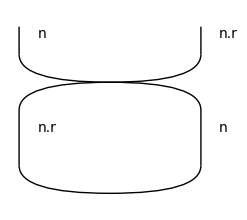

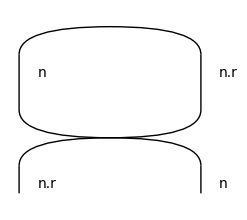

In [6]:
TwistedDiagram.cups(n, n.r).draw(figsize=(2, 2))
TwistedDiagram.caps(n.r, n).draw(figsize=(2, 2))

## Classical DisCoCat: Tensor networks

In [7]:
import numpy as np
from lambeq.backend.tensor import Box, Diagram, Dim, Id

# Dim(1) is the unit object, so disappears when tensored with another Dim
print(f'{Dim(1) @ Dim(2) @ Dim(3)=}')

Dim(1) @ Dim(2) @ Dim(3)=Dim(2, 3)


In [8]:
id_box = Box('Id Box', Dim(2), Dim(2), data=[1,0,0,1])
id_tensor = np.array([1, 0, 0, 1]).reshape((2, 2))

# the actual values of id_box and id_tensor are equal
assert (id_box.array == id_tensor).all()
print(f'{id_box.eval()=}')

id_box.eval()=array([[1., 0.],
       [0., 1.]])


In [9]:
Diagram.cups(Dim(3), Dim(3)).eval(dtype=np.int64)

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])

In [10]:
Diagram.swap(Dim(2), Dim(2)).eval(dtype=np.int64)

array([[[[1, 0],
         [0, 0]],

        [[0, 0],
         [1, 0]]],


       [[[0, 1],
         [0, 0]],

        [[0, 0],
         [0, 1]]]])

"This" becomes
[1. 1.]
"is" becomes
[[[[1. 1.]
   [1. 1.]]

  [[1. 1.]
   [1. 1.]]]


 [[[1. 1.]
   [1. 1.]]

  [[1. 1.]
   [1. 1.]]]]
"twisted" becomes
[[1. 1.]
 [1. 1.]]
one_diagram = Diagram(dom=Dim(1), cod=Dim(2), layers=[Layer(left=Dim(1), box=[This; Dim(1) -> Dim(2)], right=Dim(1)), Layer(left=Dim(2), box=[is; Dim(1) -> Dim(2, 2, 2, 2)], right=Dim(1)), Layer(left=Dim(2, 2, 2, 2, 2), box=[twisted; Dim(1) -> Dim(2, 2)], right=Dim(1)), Layer(left=Dim(2, 2, 2, 2), box=[CUP; Dim(2, 2) -> Dim(1)], right=Dim(2)), Layer(left=Dim(2, 2, 2), box=[CUP; Dim(2, 2) -> Dim(1)], right=Dim(1)), Layer(left=Dim(1), box=[CUP; Dim(2, 2) -> Dim(1)], right=Dim(2))])


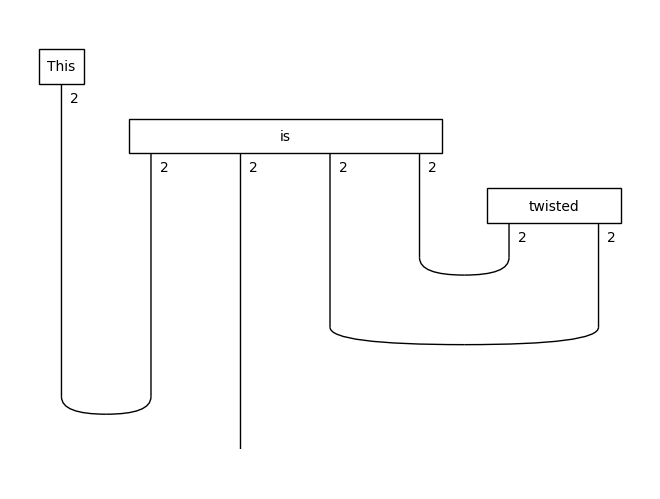

In [11]:
import numpy as np
from lambeq.backend.grammar import Functor
from lambeq.backend import tensor


def one_ob(_, ty):
    dims = [2] * len(ty)
    return Dim(*dims) # does Dim(2,2,..)

def one_ar(_, box):
    dom = one_ob(_, box.dom)
    cod = one_ob(_, box.cod)
    box = Box(box.name, dom, cod, np.ones((dom @ cod).dim))
    print(f'"{box}" becomes')
    print(box.data)
    return box

one_functor = Functor(
    target_category=tensor.tensor,
    ob=one_ob, ar=one_ar,
)
one_diagram = one_functor(diagram)
print(f'{one_diagram = }')
one_diagram.draw()

## Quantum DisCoCat: Quantum circuits

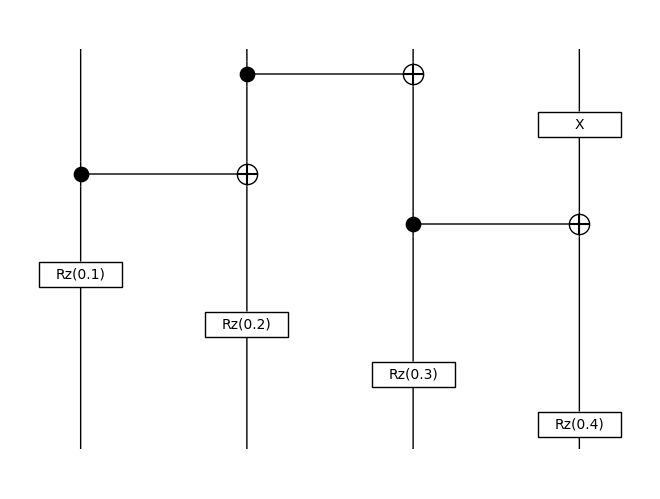

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


tk.Circuit(4).CX(1, 2).X(3).CX(0, 1).CX(2, 3).Rz(0.2, 0).Rz(0.4, 1).Rz(0.6, 2).Rz(0.8, 3)

In [12]:
from lambeq.backend.quantum import CX, Id, qubit, Rz, X


circuit = Id(4)
circuit >>= Id(1) @ CX @ X
circuit >>= CX @ CX
circuit >>= Rz(0.1) @ Rz(0.2) @ Rz(0.3) @ Rz(0.4)

same_circuit = (Id(4).CX(1, 2).X(3).CX(0, 1).CX(2, 3)
                .Rz(0.1, 0).Rz(0.2, 1).Rz(0.3, 2).Rz(0.4, 3))
assert circuit == same_circuit

circuit.draw(draw_type_labels=False)
circuit.to_tk()

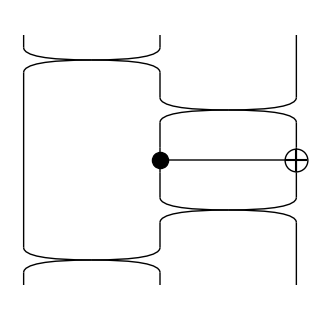

tk.Circuit(3).CX(2, 0)

In [13]:
from lambeq.backend.quantum import Diagram as Circuit, SWAP

# to apply a CNOT on qubits 2 and 0:
circuit1 = Id(3)
circuit1 >>= SWAP @ Id(1)
circuit1 >>= Id(1) @ SWAP
circuit1 >>= Id(1) @ CX
circuit1 >>= Id(1) @ SWAP
circuit1 >>= SWAP @ Id(1)

# or you can do
perm = Circuit.permutation(circuit1.dom, [2, 0, 1])
circuit2 = perm[::-1] >> Id(1) @ CX >> perm

assert circuit1 == circuit2
circuit1.draw(figsize=(3, 3), draw_type_labels=False)

# no swaps introduced when converting to tket
circuit1.to_tk()

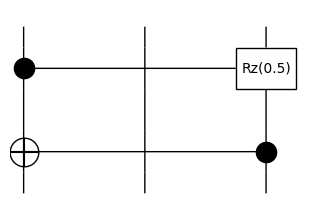

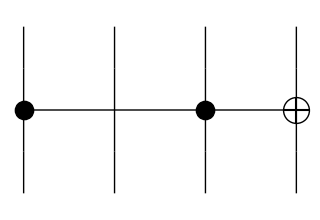

In [14]:
from lambeq.backend.quantum import Controlled, Rz, X

(Controlled(Rz(0.5), distance=2) >> Controlled(X, distance=-2)).draw(figsize=(3, 2), draw_type_labels=False)
Controlled(Controlled(X), distance=2).draw(figsize=(3, 2), draw_type_labels=False)

In [15]:
from lambeq.backend.quantum import Discard, Measure, Ket, Bra


print(f'{Discard().eval()}\n')
print(f'{Measure().eval()}\n')
print(f'{Ket(0).eval()}\n')
# circuits that have measurements in them are no longer unitary
print(f'{(Ket(0) >> Measure()).eval()}\n')

[[1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]

[[[1.+0.j 0.+0.j]
  [0.+0.j 0.+0.j]]

 [[0.+0.j 0.+0.j]
  [0.+0.j 1.+0.j]]]

[1. 0.]

[1.+0.j 0.+0.j]



In [16]:
CX.eval(mixed=True)

array([[[[[[[[1.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j]],

            [[0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j]]],


           [[[0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j]],

            [[0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j]]]],



          [[[[0.+0.j, 1.+0.j],
             [0.+0.j, 0.+0.j]],

            [[0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j]]],


           [[[0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j]],

            [[0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j]]]]],




         [[[[[0.+0.j, 0.+0.j],
             [0.+0.j, 1.+0.j]],

            [[0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j]]],


           [[[0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j]],

            [[0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j]]]],



          [[[[0.+0.j, 0.+0.j],
             [1.+0.j, 0.+0.j]],

            [[0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j]]],


           [[[0.+0.j, 0.+0.j],
             [0.+0.j, 0.+0.j]],

            [[0.+0

In [17]:
print(CX.eval().shape)
print(CX.eval(mixed=True).shape)

(2, 2, 2, 2)
(2, 2, 2, 2, 2, 2, 2, 2)


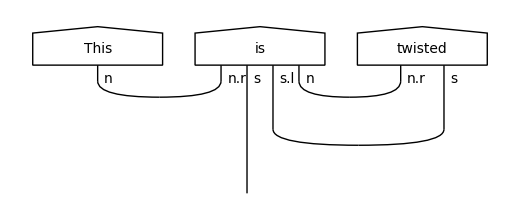

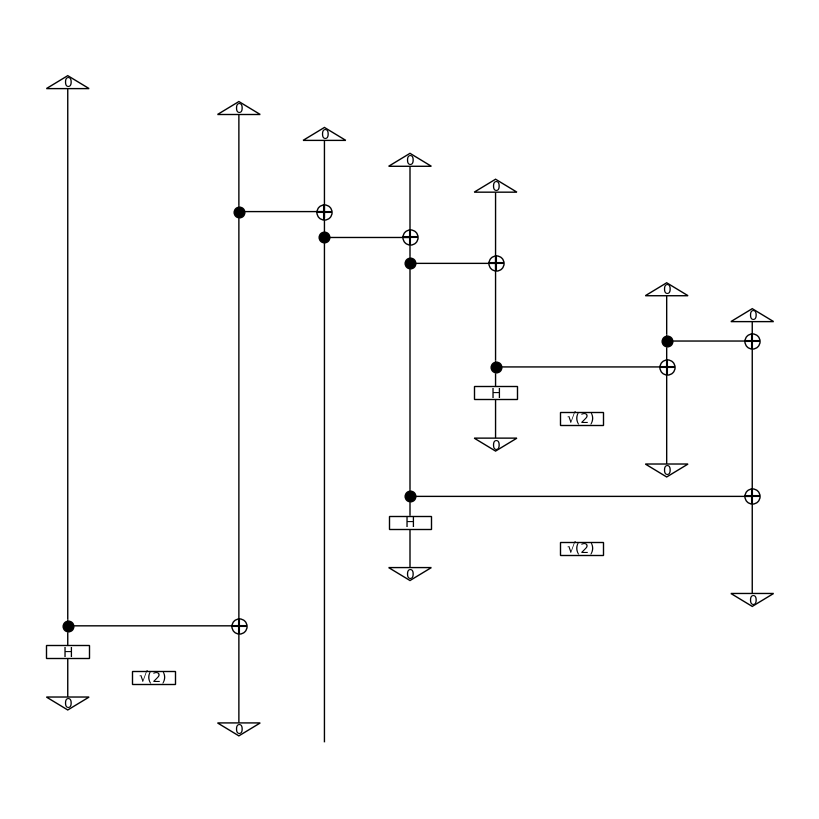

In [18]:
from lambeq.backend.grammar import Functor
from lambeq.backend.quantum import quantum, Id


def cnot_ob(_, ty):
    # this implicitly maps all rigid types to 1 qubit
    return qubit ** len(ty)

def cnot_ar(_, box):
    dom = len(box.dom)
    cod = len(box.cod)
    width = max(dom, cod)
    circuit = Id(width)
    for i in range(width - 1):
        circuit >>= Id(i) @ CX.to_diagram() @ Id(width - i - 2)

    # Add Bras (post-selection) and Kets (states)
    # to get a circuit with the right amount of
    # input and output wires
    if cod <= dom:
        circuit >>= Id(cod) @ Bra(*[0]*(dom - cod)).to_diagram()
    else:
        circuit = Id(dom) @ Ket(*[0]*(cod - dom)).to_diagram() >> circuit
    return circuit

cnot_functor = Functor(target_category=quantum, ob=cnot_ob, ar=cnot_ar)
diagram.draw(figsize=(5, 2))
cnot_functor(diagram).draw(figsize=(8, 8), draw_type_labels=False)